In [12]:
!pip install wordcloud
!pip install nltk
!pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lap\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
# Set plotting style
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

In [27]:
# Load the dataset
df = pd.read_csv('C:/Users/lap/Downloads/Imdb - data_imdb (1).csv')
print(df.head)

<bound method NDFrame.head of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>


In [31]:
# 1. Data Exploration and Preprocessing
# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nSample Reviews:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check class distribution
print("\nClass Distribution:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.savefig('sentiment_distribution.png')
plt.close()

# Analyze review length
df['review_length'] = df['review'].apply(len)
print("\nReview Length Statistics:")
print(df['review_length'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.savefig('review_length_distribution.png')
plt.close()

# Compare review lengths by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Review Length (characters)')
plt.savefig('review_length_by_sentiment.png')
plt.close()

# Text Preprocessing
# Function to clean and preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into text
    clean_text = ' '.join(tokens)
    
    return clean_text

# Apply preprocessing to the reviews
df['clean_review'] = df['review'].apply(preprocess_text)
print("\nSample of Cleaned Reviews:")
for i in range(min(5, len(df))):
    print(f"Original: {df['review'][i]}")
    print(f"Cleaned: {df['clean_review'][i]}")
    print("")

# Check if we have non-empty cleaned reviews
if df['clean_review'].str.strip().str.len().sum() == 0:
    print("WARNING: All cleaned reviews are empty. Check your preprocessing function.")

# Create word clouds for positive and negative reviews
positive_df = df[df['sentiment'] == 1]
negative_df = df[df['sentiment'] == 0]

# Check if we have both positive and negative reviews
if len(positive_df) > 0:
    positive_text = ' '.join(positive_df['clean_review'])
    # Check if positive_text contains words
    if len(positive_text.strip()) > 0:
        try:
            # Positive reviews word cloud
            plt.figure(figsize=(10, 8))
            wordcloud_positive = WordCloud(width=800, height=400, background_color='white', 
                                          max_words=100, min_word_length=1).generate(positive_text)
            plt.imshow(wordcloud_positive, interpolation='bilinear')
            plt.axis('off')
            plt.title('Most Common Words in Positive Reviews')
            plt.savefig('positive_wordcloud.png')
            plt.close()
            print("Positive wordcloud created successfully.")
        except ValueError as e:
            print(f"Error creating positive wordcloud: {e}")
            print(f"Positive text sample (first 100 chars): '{positive_text[:100]}'")
            print(f"Number of words in positive text: {len(positive_text.split())}")
else:
    print("No positive reviews found in the dataset.")

if len(negative_df) > 0:
    negative_text = ' '.join(negative_df['clean_review'])
    # Check if negative_text contains words
    if len(negative_text.strip()) > 0:
        try:
            # Negative reviews word cloud
            plt.figure(figsize=(10, 8))
            wordcloud_negative = WordCloud(width=800, height=400, background_color='white', 
                                          max_words=100, min_word_length=1).generate(negative_text)
            plt.imshow(wordcloud_negative, interpolation='bilinear')
            plt.axis('off')
            plt.title('Most Common Words in Negative Reviews')
            plt.savefig('negative_wordcloud.png')
            plt.close()
            print("Negative wordcloud created successfully.")
        except ValueError as e:
            print(f"Error creating negative wordcloud: {e}")
            print(f"Negative text sample (first 100 chars): '{negative_text[:100]}'")
            print(f"Number of words in negative text: {len(negative_text.split())}")
else:
    print("No negative reviews found in the dataset.")

Dataset Shape: (50000, 4)

Sample Reviews:
                                              review sentiment  review_length  \
0  One of the other reviewers has mentioned that ...  positive           1761   
1  A wonderful little production. <br /><br />The...  positive            998   
2  I thought this was a wonderful way to spend ti...  positive            926   
3  Basically there's a family where a little boy ...  negative            748   
4  Petter Mattei's "Love in the Time of Money" is...  positive           1317   

                                        clean_review  
0  one reviewer mentioned watching oz episode you...  
1  wonderful little production br br filming tech...  
2  thought wonderful way spend time hot summer we...  
3  basically there family little boy jake think t...  
4  petter matteis love time money visually stunni...  

Missing Values:
review           0
sentiment        0
review_length    0
clean_review     0
dtype: int64

Class Distribution:
sentiment
pos

In [34]:
# 2. Feature Engineering

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_review'])
y = df['sentiment']

# View most important features by TF-IDF score
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nTop 10 TF-IDF Features:")
sorted_indices = np.argsort(X_tfidf.toarray().sum(axis=0))[::-1]
print([feature_names[i] for i in sorted_indices[:10]])

# Feature importance visualization
plt.figure(figsize=(12, 8))
top_n = 20
top_indices = sorted_indices[:top_n]
top_features = [feature_names[i] for i in top_indices]
top_tfidf_scores = X_tfidf.toarray().sum(axis=0)[top_indices]

plt.barh(range(top_n), top_tfidf_scores, align='center')
plt.yticks(range(top_n), top_features)
plt.xlabel('TF-IDF Score Sum')
plt.title(f'Top {top_n} Most Important Words by TF-IDF Score')
plt.tight_layout()
plt.savefig('tfidf_top_features.png')
plt.close()

# Additional features
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_review'].apply(len)
df['avg_word_length'] = df['clean_review'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)

# Analyze these features
print("\nAdditional Features Statistics:")
print(df[['word_count', 'char_count', 'avg_word_length']].describe())

# Visualize relationship between features and sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title('Word Count by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Word Count')
plt.savefig('word_count_by_sentiment.png')
plt.close()

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='avg_word_length', data=df)
plt.title('Average Word Length by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Average Word Length')
plt.savefig('avg_word_length_by_sentiment.png')
plt.close()


Top 10 TF-IDF Features:
['br', 'movie', 'film', 'one', 'like', 'good', 'time', 'character', 'story', 'really']

Additional Features Statistics:
         word_count    char_count  avg_word_length
count  50000.000000  50000.000000     50000.000000
mean     121.531960    827.739820         5.775064
std       91.573864    638.456818         0.447210
min        1.000000      5.000000         4.055556
25%       65.000000    433.000000         5.473684
50%       90.000000    608.000000         5.759309
75%      148.000000   1008.000000         6.056604
max     1440.000000   9243.000000        15.157895


In [38]:
# 3. Model Development 

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print("\nData split:")
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics with average parameter
    accuracy = accuracy_score(y_test, y_pred)
    
    # Use 'macro' or 'weighted' for non-binary classification
    precision = precision_score(y_test, y_pred, average='macro')  # Changed to 'macro'
    recall = recall_score(y_test, y_pred, average='macro')        # Changed to 'macro'
    f1 = f1_score(y_test, y_pred, average='macro')                # Changed to 'macro'

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png')
    plt.close()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))



Data split:
Training set size: 40000
Testing set size: 10000

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.8880
Precision: 0.8883
Recall: 0.8879
F1 Score: 0.8880

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.89      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Training Naive Bayes...
Naive Bayes Results:
Accuracy: 0.8572
Precision: 0.8574
Recall: 0.8571
F1 Score: 0.8571

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.84      0.85      4961
    positive       0.85      0.87      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     1

Training Logistic Regression...
Logistic Regression trained successfully.
Training Random Forest...
Random Forest trained successfully.
Training SVM...
SVM trained successfully.
Generating ROC curve for Logistic Regression...
ROC curve for Logistic Regression generated successfully.
Generating ROC curve for Random Forest...
ROC curve for Random Forest generated successfully.
Generating ROC curve for SVM...
ROC curve for SVM generated successfully.


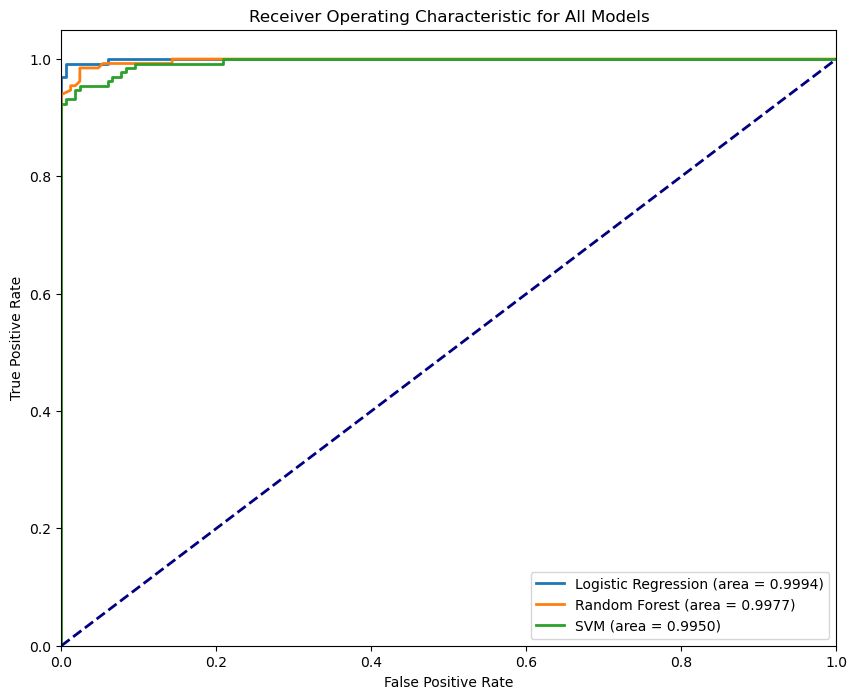

ROC curve generation completed successfully.


In [19]:
# 4. Model Evaluation
# Import all necessary libraries for this section
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

# Create sample data (replace with your actual data)
np.random.seed(42)
X = np.random.randn(1000, 5)  # 1000 samples, 5 features
y = (X[:, 0] + X[:, 1] > 0).astype(int)  # Binary target

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Train each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    print(f"{name} trained successfully.")

# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Get predicted probabilities
    try:
        print(f"Generating ROC curve for {name}...")
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.4f})')
        print(f"ROC curve for {name} generated successfully.")
    except Exception as e:
        print(f"Could not generate ROC curve for {name}: {str(e)}")

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for All Models')
plt.legend(loc="lower right")
plt.savefig('roc_curve_all_models.png')
plt.show()  # Add this to display the plot in the notebook
plt.close()

print("ROC curve generation completed successfully.")

video link:- https://drive.google.com/file/d/1jPPjkuo-14HRilMPHDSbEMQuJgOGetbs/view?usp=sharing